# Predicting Subreddits Using NLP: r/Fantasy vs. r/scifi
### Uriel Eckmann

![Fantasy vs. Scifi](../assets/SciFi_Fantasy_Venn.png)

## Problem Statement

Reddit's moderators are going on strike! After years of having to read through countless posts, the moderators have expressed feeling overwhelmed and are considering going on strike unless something is done to help them get through all the posts. Additionally, the reddit servers are beginning to become overloaded. Given the amount of crossposts that occur on a day to day basis, the servers can't maintain so many subreddits! 

Luckily, our company has recently come up with a solution for both of these problems. Our goal is to utilize Natural Language Processing to eliminate redundant subreddits while simultaneously predicting if a post actually belongs in the subreddit when submitted. We'll begin by eliminating the r/geekdom subreddit which is filled with crossposts from [r/scifi](https://www.reddit.com/r/scifi/) and [r/fantasy](https://www.reddit.com/r/fantasy/). From now on, anything posted in the r/geekdom subreddit will automatically be sorted into either r/scifi or r/fantasy through utilizing our classification model. The success of this model will be measured in it's accuracy to classify posts. If we can successfully build an accurate model, our model can then be implemented in these 2 subreddits to help moderators by automating the process by which posts are checked to ensure that they actually belong in that subreddit. Once we have built a successful model, our process can then be repeated for any number of other subreddits, streamlining the entire site, saving time for the mods, saving money on servers, and keeping users happy.

## Executive Summary
Our goal here is to create an accurate model that will predict if a written post belongs in the scifi or fantasy subreddit. The success of our model will be determined by it's accuracy.
### _Workflow_
#### _Data Collection_
The data for this project was collected using reddit's pushshift [API](https://api.pushshift.io/reddit/search/submission). This was a difficult experience, as much of the data had to be cleaned for a variety of reasons - posts wer removed from the subreddit for not following subreddit rules, deleted posts, or posts with no actual text content. Once all of the data was collected and cleaned, it was then stored as a CSV to be used in this notebook.
#### _NLP_
Because we were using text data, the data had to be converted into a format that would be usable by our model. This meant that the text itself had to be tokenized, lemmatized, and in some cases, fixed up a bit. Once the text data was cleaned, it then had to be transformed into a format that would be interpretable by a computer. We used the CountVectorizer and the TFIDFVectorizer to transform all the text into a dataframe that considered each word as a statistic as opposed to a word.
#### _Data Exploration_
After transforming our data, we were able to look at all the particular words that were most relevant to our two subreddits. While Science Fiction and Fantasy do overlap in many areas, it was quite clear that there were some important differences between the two, most importantly, the fact that r/fantasy appeared to be more reading and book focused, while r/scifi was more TV and Movies focused. 
#### _Observations_
After building several models from our data to predict the subreddit, we actually saw some success in our models. Our most successful model was the Logistic Regression Model, but it is worth noting that this particular model was overfit. Most of the models performed relatively well, and certainly did better than the baseline.

#### _Issues_
Using NLP for the first time was stressful and a handful. Learning to utilize Lemmatizing and Tokenizing was very difficult, and it did not help that lemmatizing did not alway produce the results I hoped for. While doing each did ultimately make the models better, it could still be frustrating working with them. Another critical issue was timing - running these models through a Pipeline took far too much time and often caused more frustration. It's possible that if I were to go back, I might Vectorize the text before fitting it to the model, or using RandomSearch instead of GridSearch.

## Table of Contents

### Contents:
- [Loading Packages and Data](#Loading-Packages-and-Data)
    - [Packages](#Packages)
    - [Data](#Data)
- [Data Dictionary](#Data-Dictionary)
- [Data Cleaning](#Data-Cleaning)
    - [Null Values](#Null-Values)
    - [Dropping Columns](#Dropping-Columns)
    - [Adding Columns](#Adding-Columns)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Natural Language Processing](#Natural-Language-Processing)
        - [Tokenizing and Lemmatizing](#Tokenizing-and-Lemmatizing)
        - [CountVectorizer](#CountVectorizer)
    - [Stop Words](#Stop-Words)
    - [Visualizations](#Visualizations)
- [Model Preparation](#Model-Preparation)
   - [Convert Target Value to Binary](#Convert-Target-to-Binary)
   - [Model Workflow](#Model-Workflow)
   - [Train/Test Split](#Train/Test-Split)
   - [Model Evaluator](#Model-Evaluator)
- [Modeling](#Modeling)
    - [TFIDFVectorizer](#TFIDFVectorizer)
    - [Baseline Model](#Baseline-Model)
    - [Multinomial Bayes Models](#Multinomial-Bayes-Models)
        - [Multinomial Bayes with CountVectorizer](#Multinomial-Bayes-with-CountVectorizer)
        - [Multinomial Bayes with TFIDFVectorizer](#Multinomial-Bayes-with-TFIDFVectorizer)
    - [Logistic Regressions](#Logistic-Regressions)
        - [Logistic Regression with CountVectorizer](#Logistic-Regression-with-CountVectorizer)
        - [Logistic Regression with TFIDFVectorizer](#Logistic-Regression-with-TFIDFVectorizer)
    - [Decision Trees](#Decision-Trees)
        - [Decision Tree with CountVectorizer](#Decision-Tree-with-CountVectorizer)
        - [Decision Tree with TFIDFVectorizer](#Decision-Tree-with-TFIDFVectorizer)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
    - [Confusion Matrix](#Confusion-Matrix)
    - [Coefficients and Interpretation](#Coefficients-and-Interpretation)
    - [Visualizing Coefficients](#Visualizing-Coefficients)
    - [Misclassifications](#Misclassifications)
- [Conclusion](#Conclusion)
- [Recommendations](#Recommendations)
- [References](#References)

## Loading Packages and Data
### Packages
The following below are python packages that will be necessary for creating our models.

In [ ]:
import numpy as np
import datetime as dt
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', 200)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
RANDOM_STATE = 613
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import MultinomialNB

### Data
The following data was pulled from the [Reddit API](https://api.pushshift.io/reddit/search/submission) and was cleaned in the [Data Extraction Notebook]("./Data-Extraction.ipynb). Over 5,000 rows of data were extracted from scifi and fantasy subreddits with an almost perfect split between the two. That data was stored as a CSV after being cleaned, and now we're going to use that dataframe for our model. Before we begin, we'll take a look at our dataframe to see what we're dealing with.

In [562]:
# lets pull up the dataframe using pandas read_csv
df = pd.read_csv("../data/subreddits.csv", )
df.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,LF Recommendation: Fantasy with long travel episode(s)?,Hi looking for recommendation for a top preferably well known / well-regarded fantasy novel that has as part of its story arc some sort of longer traveling section where character(s) have to trave...,Fantasy,1595295818,Overthrown77,16,5,True,2020-07-20
1,What is the best Fantasy book you've read that has three stars or less on Goodreads?,"usually I don't enjoy something below four stars, to be honest. But sometimes a 3 star book will leave me baffled at everybody's madness, wondering if I read a version from a different timeline be...",Fantasy,1595304562,OraclePreston,55,19,True,2020-07-21
2,Favorite fantasy names?,"I love fantasy, and I also have a thing for names. I’d love to hear everyone’s favorite character names from fantasy! It would also be cool to hear if anyone has named their children after their f...",Fantasy,1595305376,omnomenclature,59,17,True,2020-07-21
3,Anyone can recommend me a book without having a focus on the monarchy?,"Idk how else to put the title but I really want to get a good story of adventure on the perspective of a commoner or some mercenary, etc. It can have a monarchy in it just not have it be a focus o...",Fantasy,1595305716,UlyssesCourier,61,33,True,2020-07-21
4,It’s been 10 years since I read “The Way of Kings” the first time.,"And now, here I am, a 32 year old man, chuckling under my blanket at the mental image of 35 bridgemen marching tightly through a chaotic war amp in parshendi bone-armor. At 2 in the morning. I fee...",Fantasy,1595311158,Bock_Tea,65,126,True,2020-07-21


## Data Dictionary

|Column Name|Data Type|Description|
|---|---|---|
|title |object|Title given to the post|
|selftext |object|Main body of the post|
|subreddit |object|Which subreddit the post was from, our target|
|created_utc |int|Date and time this was posted in Epoch time|
|author |object|The username of the redditor|
|num_comments |int|The number of comments made on the post|
|score |int|The number of upvotes the post received|
|is_self |bool|Checks that the post is a text|
|timestamp |object|The date of the post in yyyy/mm/dd form|

This data dictionary helps us understand what each column in our dataframe represents. Our important columns are the `title` and `selftext` which are the contents of each post, which we'll be breaking down in order to build our models.

## Data Cleaning

### Null Values
Our data was previously cleaned to exclude null values or posts that were removed or deleted on the subreddits. As such, as far as null values goes, we have none.

In [566]:
df.isna().sum().sum()

0

### Dropping Columns
Given that we're primarily going to be using the `title` and `selftext` columns, we're going to remove the `created_utc`, `score`, `author`, and `num_comments` columns as they are unnecessary for our models. 

In [567]:
df.drop(columns = ["created_utc", "score", "author", "num_comments"], inplace = True)
df.head(2)

,title,selftext,subreddit,is_self,timestamp
0,LF Recommendation: Fantasy with long travel episode(s)?,Hi looking for recommendation for a top preferably well known / well-regarded fantasy novel that has as part of its story arc some sort of longer traveling section where character(s) have to trave...,Fantasy,True,2020-07-20
1,What is the best Fantasy book you've read that has three stars or less on Goodreads?,"usually I don't enjoy something below four stars, to be honest. But sometimes a 3 star book will leave me baffled at everybody's madness, wondering if I read a version from a different timeline be...",Fantasy,True,2020-07-21


### Adding Columns
Finally, Since we want to be able to analyze _both_ the `title` and the `selftext` columns, we're going to combine the text from both of them into one column, called `combined`

In [568]:
df["combined"] = df["title"]+ "  " + df["selftext"]
df.head(2)

,title,selftext,subreddit,is_self,timestamp,combined
0,LF Recommendation: Fantasy with long travel episode(s)?,Hi looking for recommendation for a top preferably well known / well-regarded fantasy novel that has as part of its story arc some sort of longer traveling section where character(s) have to trave...,Fantasy,True,2020-07-20,LF Recommendation: Fantasy with long travel episode(s)? Hi looking for recommendation for a top preferably well known / well-regarded fantasy novel that has as part of its story arc some sort of ...
1,What is the best Fantasy book you've read that has three stars or less on Goodreads?,"usually I don't enjoy something below four stars, to be honest. But sometimes a 3 star book will leave me baffled at everybody's madness, wondering if I read a version from a different timeline be...",Fantasy,True,2020-07-21,"What is the best Fantasy book you've read that has three stars or less on Goodreads? usually I don't enjoy something below four stars, to be honest. But sometimes a 3 star book will leave me baff..."


## Exploratory Data Analysis
Let's take a deep dive into our data, so we can fully understand what people are posting about on these subreddits and so we can see the differences between the two in order to figure out what might be helpful for us when we create our models. 

### Natural Language Processing
In order to begin looking at our data, we'll need to break apart our posts into individual words and then see their frequencies in order to make any assumptions about them. Unfortunately, much of our data is unuseable, as people often misspell names and places, as well as additional extra characters that make their way into our data as a result of how the posts were submitted onto reddit. As a result, we'll need to take this into account before we try analyzing our word frequencies.

#### Tokenizing and Lemmatizing
The first step of cleaning up our separated words is to [tokenize](https://docs.python.org/3/library/tokenize.html). Tokenization is the process by which each post is broken up into individual words and special characters are removed. This process is particularly useful, as it will allow us to manipulate certain words that we might catch later on. [Lemmatizing](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) will take individual words and remove the excess "s" that appears at the end of plural words. This will help as it will give more weight to individual words when they are combined with their plural versions.  
In the function below, unwanted characters are first removed, then we tokenize and lemmatize. Individual letters left behind as a result of lemmatization are dropped, and we also took the opportunity to take individual instances of the words "sci" and "fi" and combine them into "scifi"

In [428]:
# Some of this code is copied from Noelle Brown's lecture on NLP
def string_cleaner(string):
    # Create a list of our unwanted extra characters
    unwanted_characters = ["\n", "&amp;", "_", "amp", "gt"]
    # remove them from our strings
    for i in unwanted_characters:
        string = string.replace(i, "")

    # Instantiate tokenizer.
    tokenizer = RegexpTokenizer(r'\w+')
    # Tokenize text.
    tokens = tokenizer.tokenize(string.lower())
    # Instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    # lemmatize words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove individual characters from our strings that are left because of lemmatizing 
    for token in tokens:
        if not token.isnumeric():
            if len(token) == 1:
                tokens.remove(token)
    
    # change all "sci"'s into "scifi"
    for i in range(len(tokens)):
        if tokens[i] == "sci":
            tokens[i] = "scifi"
        if tokens[i] == "fi":
            tokens[i] = ""
    
    # bring our string back together again
    return(" ".join(tokens))

#### CountVectorizer
Our next step is to transform our dataframe into what is known as a [CountVectorized](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) Dataframe. That is: a dataframe that has all of our words as the columns and then counts how many a word appears in each post. CountVectorizer is a package from the scikit learn module for Python. It acts as a _transformer_; something that transforms our data for us. For example, the sentences "I love cats" and "I love dogs" would create a dataframe that looks like this:  

|I|love|cats|dogs|
|---|---|---|---|
|1|1|1|0|
|1|1|0|1|  

Since the first sentence does not have the word "dogs" in it, it is given the value 0 in that column. This powerful tool will take all of our individual words and create a massive dataframe using all the words of all of our posts. This will allow us to see what are the most frequent words appearing in our subreddits.

In [546]:
#Instantiate our CountVectorizer
cvec = CountVectorizer(min_df= 5, # a word must have appeared at least 5 times to make the cut
                      preprocessor = string_cleaner, # use our function above to clean the words
                      max_features = 1000) # limit the dataframe to just the top 1000 words

# fit our transformer
cvec.fit(df["combined"])
# store our transformed data
df_vect = cvec.transform(df["combined"])
# Create a new dataframe from the transformed dataset
vectorized_df = pd.DataFrame(df_vect.toarray(),
                             columns = cvec.get_feature_names())
# Let's take a look at the data
vectorized_df.head()

,10,100,12,15,20,2019,2020,90,ability,able,about,above,absolutely,across,act,action,actual,actually,add,adult,advance,advanced,adventure,after,again,against,age,ago,ai,air,alien,all,allowed,almost,alone,along,already,also,although,always,am,amazing,amazon,american,among,amount,an,ancient,and,another,answer,any,anyone,anything,anyway,appreciate,appreciated,arc,archive,are,aren,arm,around,art,artist,ask,asked,aspect,at,attention,audible,audiobook,author,available,award,away,awesome,back,background,bad,ballad,based,basically,battle,be,beautiful,became,because,become,becomes,been,before,began,begin,beginning,behind,being,believe,below,best,better,between,beyond,big,bingo,bit,black,blade,blog,blood,blue,body,bone,book,both,boy,brain,brandon,break,bring,broken,brother,brought,build,building,built,but,by,caesarakajohnhobbes,call,called,came,can,cannot,captain,card,care,case,cast,cat,cause,century,certain,certainly,chance,change,channel,chapter,character,check,child,choice,chronicle,city,civilization,class,classic,clear,close,club,cold,collection,com,combat,come,comic,coming,comment,common,community,company,complete,completely,complex,concept,conflict,consider,contact,content,continue,control,cool,copy,could,couldn,count,country,couple,course,cover,create,created,creature,crew,culture,curious,current,currently,cut,daily,dark,day,dead,deal,death,decade,decided,deep,definitely,demon,depth,description,despite,detail,development,deviantart,did,didn,die,different,difficult,discus,discussion,do,doe,doesn,doing,don,done,door,down,dp,dragon,dream,dresden,due,dune,during,each,early,earth,easily,easy,ebook,effect,either,element,else,empire,end,ended,ending,enemy,english,enjoy,enjoyed,enough,entire,entirely,entity,epic,episode,escape,especially,etc,even,event,eventually,ever,every,everyone,everything,evil,exactly,excellent,except,excited,exist,exle,exles,expanse,expect,experience,explain,extremely,eye,face,fact,fall,familiar,family,fan,fantastic,fantasy,far,fast,father,favorite,favourite,fear,feature,featuring,feel,feeling,felt,female,few,fiction,fight,fighting,figure,file,film,final,finally,find,finding,fine,finish,finished,fire,first,fit,five,focus,follow,following,for,force,form,forward,found,four,free,friend,from,full,fun,further,future,galaxy,game,gave,general,generally,genre,get,getting,ghost,giant,girl,give,given,giving,go,goal,god,going,gone,good,goodreads,google,got,government,great,grimdark,ground,group,grow,guess,gun,guy,ha,had,half,hand,happen,happened,happens,happy,hard,harry,hate,have,haven,having,he,head,hear,heard,heart,heavy,hell,hello,help,her,here,hero,herself,hey,hi,high,higher,highly,him,himself,his,history,hit,hold,hole,home,honestly,hope,hoping,horror,hour,house,how,however,http,huge,human,humanity,hundred,ice,idea,if,im,image,imagine,important,in,include,including,individual,information,inside,inspired,instead,interest,interested,interesting,into,is,isn,issue,it,itself,job,john,join,journey,jpg,july,june,just,karakurta,keep,kept,kid,kill,killed,kind,kindle,king,kingdom,knew,know,knowledge,known,lack,land,language,large,last,late,later,law,le,lead,learn,least,leave,left,let,level,lie,life,light,like,liked,limited,line,link,list,listen,literally,little,live,living,ll,locke,long,longer,look,looked,looking,lord,lost,lot,lotr,love,loved,low,lt,machine,made,magic,magical,main,major,make,making,malazan,male,man,many,mark,mass,matter,may,maybe,mc,me,mean,medieval,medium,meet,member,memory,men,mention,mentioned,michael,middle,might,military,mind,mine,minute,missing,mission,mistborn,mode,modern,moment,money,monster,month,moon,more,most,mostly,mother,move,movie,mr,much,multiple,murder,music,must,my,myself,mysterious,mystery,name,narrative,nature,nbsp,near,nearly,need,needed,never,new,next,nice,night,no,non,not,note,nothing,novel,now,number,obviously,of,off,often,oh,ok,okay,old,older,on,once,one,online,only,open,opinion,or,order,org,original,other,others,our,out,outside,over,overall,own,page,part,particular,particularly,past,path,pea

### Stop Words
As we explore and model our data, we'll begin to notice that there are certain words that are normal conversational words that don't have any affect as to whether or not these words belong in any particular subreddit. These words are known as [Stop Words](https://towardsdatascience.com/stop-words-in-nlp-5b248dadad47#:~:text=What%20are%20stop%20words%3F,at%2C%20which%2C%20and%20on.). When implemented, these words will be removed from the dataframe to make way for the more important words that have a bigger impact. Below is a personal list of stop words that will be implemented in later models and visualizations

In [572]:
my_stopwords = ["a", "an", "the", "them", "those", "then", "by", "who", "what", "where", "when", "and", "of", "to", "in",
            "it", "is", "that", "for", "you", "this", "but", "with", "as", "on", "was", "are", "be", "or", "have",
             "like", "not", "my", "so", "https", "they", "about", "from", "if", "he", "all", "there", "just", "com",
             "me", "at", "one", "can", "some", "more", "his", "we", "out", "would", "her", "www", "has","she", "up", 
             "any", "their", "do", "ve", "how", "really", "into", "which", "think", "had", "will", "know", "been",
             "also", "get", "people", "good", "your", "don", "no", "only", "were", "much", "here", "wa", "something",
             "could", "well", "even", "most", "way", "want", "because", "than", "very", "new", "now", "ha", "http", 
             "thing", "am", "these", "see", "le", "make", "lot", "thread"] 

### Visualizations
Below is a function that creates a horizontal bar plot showing the representation of the most common words in our dataframe. 

In [550]:
def show_most_words (dataframe, column, title, word_freq = 5, stop_word_list = None, limiter = 9000):
    cvec = CountVectorizer(min_df= word_freq,
                          preprocessor = string_cleaner,
                          stop_words = stop_word_list)
    
    cvec.fit(dataframe[column])

    df_vect = cvec.transform(dataframe[column])

    vectorized_df = pd.DataFrame(df_vect.toarray(),
                                 columns = cvec.get_feature_names())

    # get count of top-occurring words
    # empty dictionary
    top_words = {}

    # loop through columns
    for i in vectorized_df.columns:
        # save sum of each column in dictionary
        top_words[i] =  vectorized_df[i].sum()

    # top_words to dataframe sorted by highest occurance
    most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))

    plt.figure(figsize=(10,8))

    word_list = list(most_freq[0])
    word_list = [word.title() for word in word_list]

    sns.barplot(data = most_freq, 
                x = most_freq[1][:20], 
                y = word_list[:20])

    plt.xlim(0, limiter)
    plt.title(title, fontsize = 24)
    plt.xlabel("Frequency of Word", fontsize = 20)
    plt.ylabel("Words", fontsize = 20)
    plt.tick_params(labelsize=14);

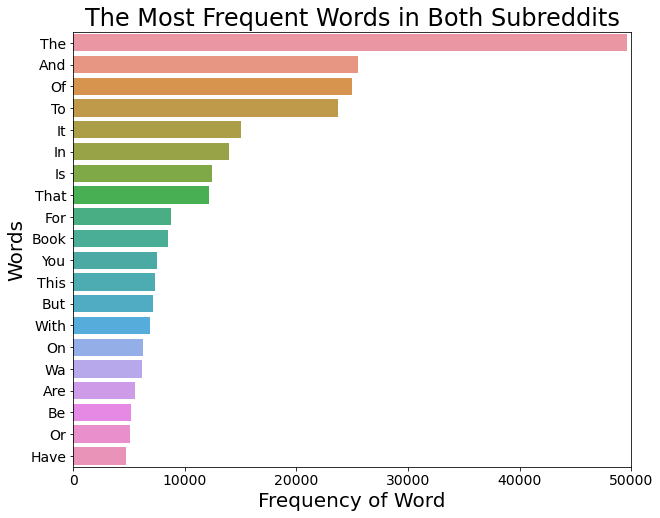

In [555]:
# use our function withot any stopwords on all the data
show_most_words(df, "combined", "The Most Frequent Words in Both Subreddits", limiter = 50000)

__Interpretation:__ As we can see, many of the most common words that appear in our dataset are normal, conversational words that have no indication as to whether or not they came from one subreddit or the other, such as: `The`, `And`, `Of`, `To`, and `It`, each of which appear over 20,000 times. If we really want to find th words that will be interpretable, we'll need to implement our stop words. 

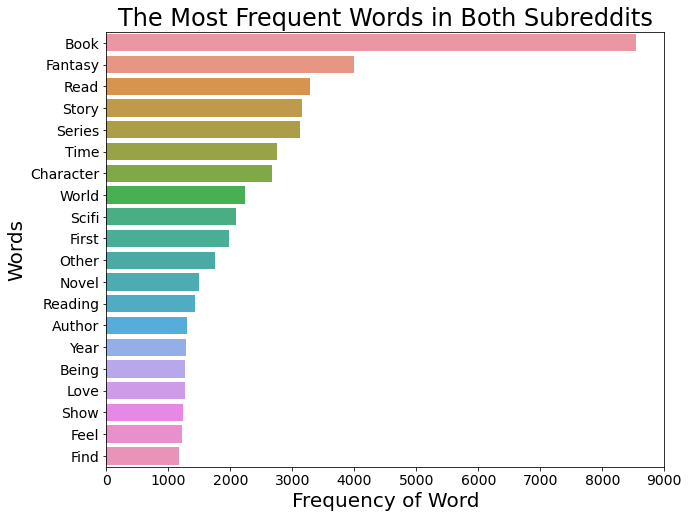

In [556]:
# call the function on all the data with the stopwords
show_most_words(df, "combined", "The Most Frequent Words in Both Subreddits", stop_word_list = my_stopwords)

__Interpretation:__ Now that we've removed the stopwords, we can see a more clear picture as to what words are important within our dataframe and our subreddits. Given the nature of these subreddits, we can see some common themes. For example, many of the discussions on both subreddits will be about Science fiction and Fantasy Books. As such, we get some popular words such as: `Book`, `Read`, `Story`, `Series`, `Novel`, `Reading`, and `Author`. 

Other words have clear deliniations, such as `Scifi` and `Fantasy`, which each obviously came from their individual subreddits. Some of these words are more common words that are used to display emotion, such as `Feel`, `Love`, and `Find`.  

The interesting words that stick out to me are `Show` and `Time`. `Show` could be indicative of a television show, or just be referencing how we are shown something. `Time` on the other hand is a real curveball, as it could apply to both subreddits - for r/fantasy, it could be a reference to the Wheel of Time series, a famous popular fantasy series. for r/scifi, it could be a reference to time travel, a common trope in science fiction. If we delve deeper into each individual subreddit, we may find some answers. 

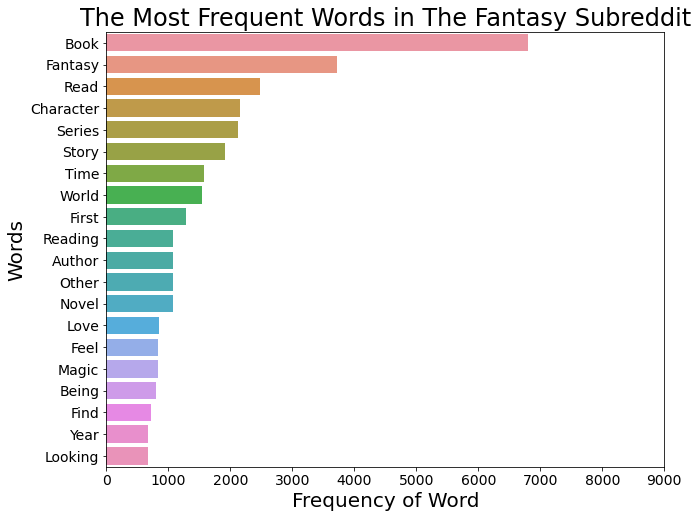

In [573]:
# call the data with stopwords ONLY on posts from r/fantasy
show_most_words(df.loc[df["subreddit"] == "Fantasy", ["title", "selftext", "subreddit", "combined"]],
                "combined", "The Most Frequent Words in The Fantasy Subreddit",
               stop_word_list = my_stopwords)

__Interpretation:__ This plot truly clarifies some of our questions from before regarding deliniations between the 2 subreddits. Obviously, the word `Fantasy` appearing so much makes sense, but there are some other hints here for us as well. Most of the popular words reference reading materials, such as `Book`, `Read`, `Series`, `Story`, `Author`, `Novel`, and `Reading`.  

Some of the other popular words are very indicative of the subreddit, such as `Being`, and `Magic`, as those are things typically unique to the fantasy genre, especially given the number of different fantastical species across thousands of books. 

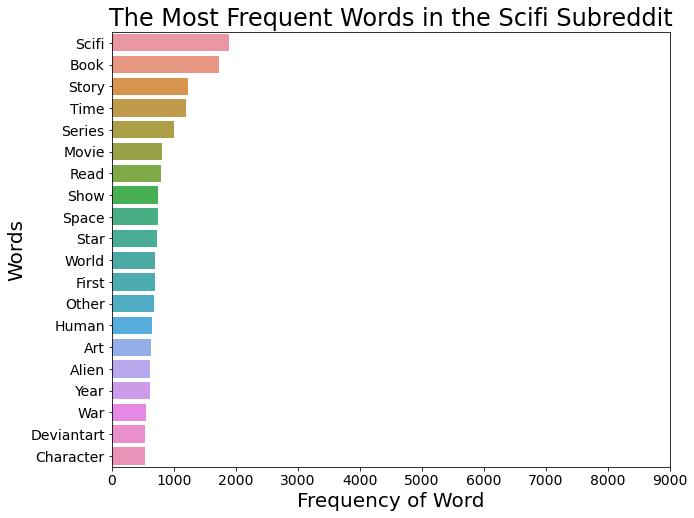

In [574]:
# call the data with stopwords ONLY on posts from r/scifi
show_most_words(df.loc[df["subreddit"] == "scifi", ["title", "selftext", "subreddit", "combined"]], 
                "combined", "The Most Frequent Words in the Scifi Subreddit",
               stop_word_list = my_stopwords)

__Interpretation:__ We can see that r/scifi actually has a lot of differences from r/fantasy. For one, while there is still a strong emphasis on books and reading, we can see that it isn't nearly as strong as r/fantasy, and we can see that there is actually a strong focus on TV and Movies. `Movie` and `Show` appear, where they did not in r/fantasy, given the fact that there is far more material there for Science Fiction as opposed to Fantasy.  

This is particularly apparent with words such as `Star`, `Space`, and `Alien`, which could all be references to such popular franchises such as Star Wars and Star Trek.  

There also appears to be more of an emphasis on artwork as we see `Art` and `Deviantart` make appearances. Either way, we're beginning to see more of a clear picture when it comes to these subreddits and how they might be deliniated.

## Model Preparation

### Convert Target Value to Binary
Because we're attempting to determine subreddits, we need to convert target into something that our model can aim for - namely, a boolean value, a `1` or a `0`. As such, we're going to transform our the value `Fantasy` into a `1`, and `scifi` into a `0`.

In [575]:
# utilize .map to change our values
df["subreddit"] = df["subreddit"].map({"Fantasy" : 1, "scifi" : 0})
df["subreddit"].value_counts(normalize = True)

0    0.502274
1    0.497726
Name: subreddit, dtype: float64

What we're displaying above is the percentage of each of our 2 subreddits within our data. 50.2% of the data is from r/scifi, while 49.8% of the data is from r/fantasy. These values will be important in a moment when we establish our baseline model.

### Model Workflow
In order to create the best possible model, each model will be produced using the following iterative process.  

- Train/Test Split  

- Establish a baseline.  

- Create a new model using: 
    1. A Pipeline. Each Pipeline will have:
        - A transformer (CountVectorizer, TFIDFVectorizer)
        - An estimator (Logistic Regression, Decision Tree, etc.
    2. Pipeline HyperParameters
    3. Advanced Grid Search
        - This will help determine which HyperParameters are the most ideal
    4. An Accuracy Dataframe containing:
        - Training Accuracy
        - Testing Accuracy
        - The Cross Validation Mean
        - Each Cross Validation Accuracy

Each model will be run several times as the HyperParameters are narrowed down to the most ideal.

### Train/Test Split
At this point, we will choose our features and our target, and split them so as to avoid overfitting our model. The train set will be used by the estimators to build a model, and then the test set will be applied to the model to see how it compares to the baselin model.

In [514]:
# features
X = df["combined"]
# target
y = df["subreddit"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = RANDOM_STATE, stratify = y)

### Model Evaluator
In order to see the accuracy of each test, below is a function that will produce a dataframe that shows us the accuracy scores of the training data, testing data, and cross validations.

In [515]:
# This function was created by me for project 2
def scores_df(model, training_df, testing_df, model_name):
    # Start with a list of our different scores
    list1 = ["Training Accuracy", "Testing Accuracy", "Cross Validation Mean"]
    # create a list with our actual scores
    list2 = [round(model.score(training_df, y_train), 3), 
             round(model.score(testing_df, y_test), 3),
             round(cross_val_score(model, training_df, y_train, cv = 5).mean(), 3)]
    # Loop through all 5 cross validations and return the scores on each one.
    for position, i in enumerate(cross_val_score(model, training_df, y_train, cv = 5)):
        # add our new row name
        list1.append(f"Cross Validation Accuracy, Fold {position + 1}") 
        # add the cross val score
        list2.append(round(i, 3))
        
    # This dataframe initiation was copied from https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/
    df = pd.DataFrame(list(zip(list1, list2)), 
               columns =[model_name, 'Score'])
    return df

## Modeling

### TFIDFVectorizer
One important thing to know is the TFIDFVectorizer. This is a transformer that we will be using that transforms the dataframe similar to the CountVectorizer, but instead of assigning values of whole numbers based on how many times the word appears in the post, it instead assigns a value based on the word's appearance in the entire corpus. This can give certain words more or less weight, which is useful in a classification problem such as this one. 

### Baseline
The baseline model provides a low threshold that we'll need to beat to have any success in our models.

In [516]:
y_train.value_counts(normalize = True)

0    0.502373
1    0.497627
Name: subreddit, dtype: float64

In [598]:
y_test.value_counts(normalize = True)

0    0.501976
1    0.498024
Name: subreddit, dtype: float64

__Interpretation:__ Our baseline model's accuracy would be as such - if it predicted that every post came from r/fantasy, it would be 50% correct in it's predictions.

### Multinomial Bayes Models
Given the unique nature of NLP, utilizing a Naive Bayes model is actually not the best, but it does typically produce good models. In this circumstance, we've opted to use the Multinomial Bayes option, as our values, namely the number of words, are positive integers. Naive Bayes, works by using probability, such that, the probability A, the post belongs in r/fantasy, given B, the words in the post.

#### Multinomial Bayes with CountVectorizer

In [641]:
nb_cvec_pipe = Pipeline([ 
                ("cvec", CountVectorizer(lowercase = True, preprocessor = string_cleaner)),
                ("nb", MultinomialNB())
])

pipe_params = {
    "cvec__stop_words"   : [my_stopwords],
    "cvec__min_df"       : [10],
    "cvec__max_features" : [1500],
    "cvec__ngram_range"  : [(1,1)],
    "nb__alpha"          : [0.7],
}

gs = GridSearchCV(nb_cvec_pipe,
                 pipe_params,
                 cv = 5)

results = gs.fit(X_train, y_train)
# results.best_params_

scores_df(results, X_train, X_test, "Multinomial Bayes Model with CountVectorizer")

,Multinomial Bayes Model with CountVectorizer,Score
0,Training Accuracy,0.901
1,Testing Accuracy,0.877
2,Cross Validation Mean,0.885
3,"Cross Validation Accuracy, Fold 1",0.884
4,"Cross Validation Accuracy, Fold 2",0.880
5,"Cross Validation Accuracy, Fold 3",0.888
6,"Cross Validation Accuracy, Fold 4",0.875
7,"Cross Validation Accuracy, Fold 5",0.898


#### Multinomial Bayes with TFIDFVectorizer

In [597]:
nb_tfidf_pipe = Pipeline([ 
                ("tfidf", TfidfVectorizer(lowercase = True)),
                ("nb", MultinomialNB())
])

pipe_params6 = {
    "tfidf__stop_words"   : ["english"],
    "tfidf__min_df"       : [10],
    "tfidf__max_features" : [1000],
    "tfidf__ngram_range"  : [(1,1)],
    "nb__alpha"          : [0.001],
}

gs6 = GridSearchCV(nb_tfidf_pipe,
                 pipe_params6,
                 cv = 5)

results6 = gs6.fit(X_train, y_train)
# results6.best_params_

scores_df(results6, X_train, X_test, "Multinomial Bayes Model with TFIDFVectorizer")

,Multinomial Bayes Model with TFIDFVectorizer,Score
0,Training Accuracy,0.890
1,Testing Accuracy,0.874
2,Cross Validation Mean,0.874
3,"Cross Validation Accuracy, Fold 1",0.871
4,"Cross Validation Accuracy, Fold 2",0.860
5,"Cross Validation Accuracy, Fold 3",0.879
6,"Cross Validation Accuracy, Fold 4",0.869
7,"Cross Validation Accuracy, Fold 5",0.892


### Logistic Regressions

#### Logistic Regression with CountVectorizer

In [642]:
log_cvec_pipe = Pipeline([ 
                ("cvec", CountVectorizer(lowercase = True, preprocessor = string_cleaner)),
                ("logreg", LogisticRegression(solver = "newton-cg", max_iter = 1000))
])

pipe_params1 = {
    "cvec__stop_words"   : [my_stopwords],
    "cvec__min_df"       : [5],
    "cvec__max_features" : [1000],
    "cvec__ngram_range"  : [(1,2)],
    "logreg__penalty"    : ["l2"],
    "logreg__C"          : [0.01, 0.1, 1]
}

gs1 = GridSearchCV(log_cvec_pipe,
                 pipe_params1,
                 cv = 5)

results1 = gs1.fit(X_train, y_train)
# results1.best_params_

scores_df(results1, X_train, X_test, "Logistic Regression Model with CountVectorizer")

,Logistic Regression Model with CountVectorizer,Score
0,Training Accuracy,0.945
1,Testing Accuracy,0.877
2,Cross Validation Mean,0.879
3,"Cross Validation Accuracy, Fold 1",0.885
4,"Cross Validation Accuracy, Fold 2",0.872
5,"Cross Validation Accuracy, Fold 3",0.867
6,"Cross Validation Accuracy, Fold 4",0.888
7,"Cross Validation Accuracy, Fold 5",0.881


#### Logistic Regression with TFIDFVectorizer

In [658]:
log_tfidf_pipe = Pipeline([ 
                ("tfidf", TfidfVectorizer(lowercase = True, preprocessor = string_cleaner)),
                ("logreg", LogisticRegression(solver = "newton-cg", max_iter = 1000))
])

pipe_params2 = {
    "tfidf__stop_words"   : [my_stopwords],
    "tfidf__min_df"       : [18],
    "tfidf__max_features" : [2000],
    "tfidf__ngram_range"  : [(1,1)],
    "logreg__penalty"     : ["l2"],
    "logreg__C"           : [3]
}

gs2 = GridSearchCV(log_tfidf_pipe,
                 pipe_params2,
                 cv = 5)

results2 = gs2.fit(X_train, y_train)
# results2.best_params_

scores_df(results2, X_train, X_test, "Logistic Regression Model with TFIDFVectorizer")

,Logistic Regression Model with TFIDFVectorizer,Score
0,Training Accuracy,0.966
1,Testing Accuracy,0.897
2,Cross Validation Mean,0.896
3,"Cross Validation Accuracy, Fold 1",0.892
4,"Cross Validation Accuracy, Fold 2",0.892
5,"Cross Validation Accuracy, Fold 3",0.884
6,"Cross Validation Accuracy, Fold 4",0.897
7,"Cross Validation Accuracy, Fold 5",0.916


### Decision Trees

#### Decision Tree with CountVectorizer

In [540]:
dec_tree_cvec_pipe = Pipeline([
                ("cvec", CountVectorizer(lowercase = True)),
                ("dt", DecisionTreeClassifier(random_state = RANDOM_STATE))
])

pipe_params3 = {
    "cvec__stop_words"   : ["english"],
    "cvec__min_df"       : [9],
    "cvec__max_features" : [900],
    "cvec__ngram_range"  : [(1,2)],
    "dt__max_depth"      : [10],
    "dt__min_samples_split": [20],
    "dt__min_samples_leaf" : [4],
    

}

gs3 = GridSearchCV(dec_tree_cvec_pipe,
                 pipe_params3,
                 cv = 5)

results3 = gs3.fit(X_train, y_train)

# results3.best_params_

scores_df(results3, X_train, X_test, "Decision Tree Model with CountVectorizer")

,Decision Tree Model with CountVectorizer,Score
0,Training Accuracy,0.884
1,Testing Accuracy,0.854
2,Cross Validation Mean,0.859
3,"Cross Validation Accuracy, Fold 1",0.841
4,"Cross Validation Accuracy, Fold 2",0.856
5,"Cross Validation Accuracy, Fold 3",0.861
6,"Cross Validation Accuracy, Fold 4",0.879
7,"Cross Validation Accuracy, Fold 5",0.858


#### Decision Tree with TFIDFVectorizer

In [659]:
dec_tree_tfidf_pipe = Pipeline([
                ("tfidf", TfidfVectorizer(lowercase = True)),
                ("dt", DecisionTreeClassifier(random_state = RANDOM_STATE))
])

pipe_params4 = {
    "tfidf__stop_words"   : ["english"],
    "tfidf__min_df"       : [8],
    "tfidf__max_features" : [500],
    "tfidf__ngram_range"  : [(1, 2)],
    "dt__max_depth"       : [10],
    "dt__min_samples_split": [25],
    "dt__min_samples_leaf" : [6],
    

}

gs4 = GridSearchCV(dec_tree_tfidf_pipe,
                 pipe_params4,
                 cv = 5)

results4 = gs4.fit(X_train, y_train)

# results4.best_params_

scores_df(results4, X_train, X_test, "Decision Tree Model with TFIDFVectorizer")

,Decision Tree Model with TFIDFVectorizer,Score
0,Training Accuracy,0.885
1,Testing Accuracy,0.843
2,Cross Validation Mean,0.847
3,"Cross Validation Accuracy, Fold 1",0.830
4,"Cross Validation Accuracy, Fold 2",0.851
5,"Cross Validation Accuracy, Fold 3",0.839
6,"Cross Validation Accuracy, Fold 4",0.858
7,"Cross Validation Accuracy, Fold 5",0.856


## Model Selection

Model Name | Training Accuracy | Testing Accuracy
-|-|-
Baseline | 49.8% | 49.7%
Multinomial Bayes With CountVectorizer | 90.1% | 87.7%
Multinomial Bayes With TFIDFVectorizer | 89.0% | 86.4%
Logistic Regression With CountVectorizer | 94.5% | 87.7%
Logistic Regression With TFIDFVectorizer | 96.3% | 89.7%
Decision Tree With CountVectorizer | 88.4% | 85.4%
Decision Tree With TFIDFVectorizer | 88.2% | 84.9%
  
  
Our best predictive model was the Logistic Regression model, which had a Testing Accuracy of 89.7%. This model was our best predictive model, and our most interpretable model as well. It is important to recognize that this model is overfit, and as such, is imperfect.

## Model Evaluation

### Confusion Matrix
Given the nature of our model, we'll want to see how it did in terms of classifying our different subreddits. To do this, we'll utilize a confusion matrix that compares our predictions to the reality. 

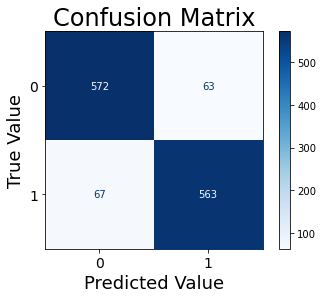

In [649]:
# plot a confusion matrix
plot_confusion_matrix(results2, X_test, y_test, cmap='Blues', values_format='d')
plt.tick_params(labelsize=14)
plt.title("Confusion Matrix", fontsize = 24)
plt.xlabel("Predicted Value", fontsize = 18)
plt.ylabel("True Value", fontsize = 18);

__Interpretation:__ This confusion matrix illustrates how our model performed. The upper left corner represents True Negatives, which are all the posts in the Test set that were predicted to be from r/scifi and actually were. The upper right represents all of the False Positives, which are all the posts in that were predicted to be in r/fantasy, but were actually from r/scifi. The bottom left are the False Negatives - posts predicted to be from r/scifi, but were actually from r/fantasy, and finally we have the bottom right, the True Positives, which are posts predicted to be from r/fantasy and actually were. It's important to recognize that from our 1,265 entries in our testing data, 130 were misclassified.

### Coefficients and Interpretation
What are the coefficients of our model, and what do they mean? We'll start by creating a dataframe of our coefficients, the words, and their values.

In [650]:
# This code was pulled from Mahdi's Logistic Regression lecture

# Setting up dataframe just for visualization
coef_df = pd.DataFrame() # empty dataframe
coef_df["coef"]    = results2.best_estimator_[1].coef_[0]
coef_df["exp_coef"] = np.exp(coef_df["coef"]) # exponentiate
coef_df["feature"] = results2.best_estimator_.named_steps["tfidf"].get_feature_names() # making human readable
coef_df = coef_df.sort_values("exp_coef", ascending = False) # sorting

# filtering only top and bottom 5
coef_df = pd.concat([coef_df.iloc[:15, :], coef_df.iloc[-15:, :]])
coef_df

,coef,exp_coef,feature
609,12.970534,429567.519984,fantasy
1071,4.507605,90.704351,magic
214,4.206413,67.115376,book
966,3.388936,29.634401,king
279,3.131756,22.914171,character
197,3.068730,21.514564,bingo
1493,2.853262,17.344264,sanderson
1058,2.485366,12.005509,lotr
1951,2.433945,11.403783,witcher
484,2.431177,11.372261,dragon


__Interpretation:__ All else held equal, for a 1 unit increase in any of these words, an observation is $e^{\beta_i}$ TIMES AS LIKELY to be a post from r/fantasy.

An example we will use will be if the word `Sanderson` appears in a post. (Brandon Sanderson is a famous Fantasy author)

All else held equal, for a for word increase of the word `Sanderson`, a post is $e^{\beta_1} = e^{2.85} = 17.3$ TIMES as likely to be from r/fantasy. As we can see, the words from r/scifi will have values that will drive the value down to 0, while the words associated with r/fantasy will drive the values up to 1.

### Visualizing Coefficients

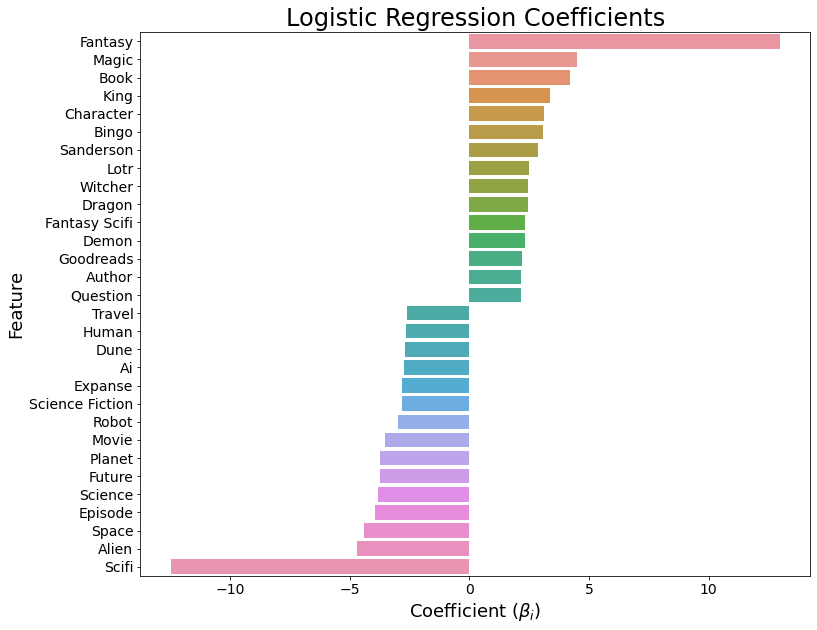

In [651]:
plt.figure(figsize=(12,10))

capital_list = list(coef_df["feature"])
capital_list = [word.title() for word in capital_list]

sns.barplot(data = coef_df, x = "coef", y = capital_list)

plt.title("Logistic Regression Coefficients", fontsize = 24)
plt.xlabel(r"Coefficient $(\beta_i)$", fontsize = 18)
plt.ylabel("Feature", fontsize = 18)
plt.tick_params(labelsize=14);

__Interpretation:__ These coefficients truly make sense when you consider the scifi and fantasy genres. For example, our words that have strong coefficients for fantasy are words like: `Witcher`, `Demon`,`Magic`, `Dragons`, `Kings`, and `lotr`, the abbreviation for The Lord of the Rings, one of the most famous fantasy epics. Given that r/fantasy is more focused on books, it's no surprise to see so many words related to books and reading being stronger coefficients. One interesting anomaly is the inclusion of the word `Bingo`. This is because r/fantasy produces a bingo card every year, and it's standard for users to read as many of the books on the bingo card as possible.  
In regards to r/scifi, the coefficients there make sense as well. Some are associated to TV and movies, such as `Episode` and `Expanse`, a scifi TV Show, as well as the word `Movie` itself. Other words such as `Space`, `Alien`, `Star`, `Planet`,`Science`, `AI`, `Robot`, and `Future` are all words highly associated with the scifi genre. Finally, the word `Dune` sticks out, as it's one of the most famous scifi book series ever written.  

### Misclassifications
As we saw earlier, some of our posts were misclassified as r/fantasy or r/scifi. let's take a look at those individual posts to see if we can see why that happened. 

In [652]:
def misclassified(model, X, y, dataframe):
    preds = model.predict(X)
    misclass = preds != y
    
    df = pd.DataFrame({
        "Post" : dataframe[misclass],
        "Predicted Subreddit" : preds[misclass],
        "Actual Subreddit"    : y[misclass]
    })
    
    return df

In [655]:
misclassified(results2, X_test, y_test, X_test).head()

,Post,Predicted Subreddit,Actual Subreddit
3632,"Best Jules Verne Translator? I know his work is often butchered in early (read. Public Domain) translations, who do I go to for an accurate modern translation?",1,0
3856,"A question about Looper (spoilers). I get the ending, but there’s one thing I didn’t get. How Is the Gat guy able to catch Old Joe at the second kids house? I believe he tells Jeff Daniels that...",1,0
1566,The Prophecy ~ A sci fi / fanatasy Story Hi \n\n\nThis is my first post here on reddit. I have wrote a sci fi fantasy story and have created it as an audiobook. My aspiration would be for it ...,0,1
642,"Books exploring the everyday of long lived beings? Say, Elrond. The heck he was doing every day for _six thousand_ years? Remember the 72519 stones [scene](https://i.imgur.com/hbSXYlR.jpg)? (whic...",0,1
2033,The Long Way to a Small Angry Planet is $2.99 Today on Kindle! [https://www.amazon.com/Long-Small-Angry-Planet-Wayfarers-ebook/dp/B00ZP64F28/ref=tmm\_kin\_swatch\_0?\_encoding=UTF8&amp;qid=159039...,0,1


__Interpretation:__ Just looking as some of these posts, it's easy to understand why they were misclassified based on our coeffiecients. 
- The first post is about Jules Verne, a scifi author. Since his works are novels, the model predicted this to be for r/fantasy, since it's a post about books.
- We see the opposite effect on the last post. A book with the word "Planet" in the title is predicted to be r/scifi when it's really r/fantasy
- The middle one is really messing with the model, since it has both "scifi" and "fantasy" mentioned multiple times. However, since the user misspelled the word "fantasy" once, the model went with the majority, of r/scifi.

If we went through all 130 posts, we'd be able to definitively see what caused the misclassification, which is a good sign for our model - it means we can catch it's mistakes. 

## Conclusion 

Our model performed relatively well! Considering that if we compare our model's accuracy to the baseline's accuracy, we have relative success in that regard. It should be noted that our model is overfit, and as such, will need some work, we can definitively say that this problem can be fixed. Given that this was our first iteration, This is a success.

Reddit can inform the moderators that they will soon be implementing automated models that will help the moderators determine if a post is fine. Additionally, r/geekdom will soon be discontinued, freeing up much needed space on the servers. Looking to the future, Reddit will be able to implement these models soon and will vastly improve their user experience. 

## Recommendations

As stated earlier, the work is not yet done. This model still needs improvement, and no model will ever be perfect. One thing to consider is that there are a few steps that should be taken:
1. Continue building models with more data. As more data is collected, the models will each improve.
2. Consider using other classification models. There are plenty of other models that were not used in this first iteration. As such, models such as KNN, LASSO Classifiers, and others would be useful to try.
3. In that regard, Boosting current models is another great suggestion, that will improve the current models. 
4. Another option would be for these models to be used in an ensemble. Utilizing the "Wisdom of the Crowd" is a great way to ensure a model that will predict as best as possible. 
5. Finally, since no model will be perfect, one thing to consider is that we have a threshold of 0.5 in regards to the probability of a post that will determine which subreddit it goes to. We can use the probabilities to determine that certain posts are not necessarily going to be classified correctly, and need to be submitted to the moderators. Using a range from 0.4 - 0.6 will cut down on 80% of the posts needing review, and will ensure that earlier iterations of the model can be used, while minimizing the error. 

## References
- [Reddit API](https://api.pushshift.io/reddit/search/submission)
- [Reddit](https://reddit.com/)
- [r/fantasy](https://www.reddit.com/r/fantasy/)
- [r/scifi](https://www.reddit.com/r/scifi/)
- [Stop Words](https://towardsdatascience.com/stop-words-in-nlp-5b248dadad47#:~:text=What%20are%20stop%20words%3F,at%2C%20which%2C%20and%20on.)
- [tokenizing](https://docs.python.org/3/library/tokenize.html)
- [Lemmatizing](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)
- [CountVectorization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
- [Matplotlibrary Tick Parameters](https://dfrieds.com/data-visualizations/style-plots-python-matplotlib.html#:~:text=For%20the%20methods%20title%20%2C%20xlabel,smaller%20fonts%20than%20axes%20labels.)